In [ ]:

    i = 0
    j = 0
    Emin = np.min(Espace)
    while Espace[i] == Emin:
        i+=1
        j = i
    print(j)
    print(Xspace[3])

C:\Users\rayne\AppData\Local\Temp\ipykernel_22380\2294976098.py:129: OptimizeWarning: Covariance of the parameters could not be estimated
  ther, pcov = curve_fit(theoretical_dispersion, Xspace, Espace, p0=[0.000028,5])
C:\Users\rayne\AppData\Local\Temp\ipykernel_22380\2294976098.py:134: OptimizeWarning: Covariance of the parameters could not be estimated
  ther_, pcov_ = curve_fit(theoretical_dispersion, X_space, E_space, p0=[0.000028,5])


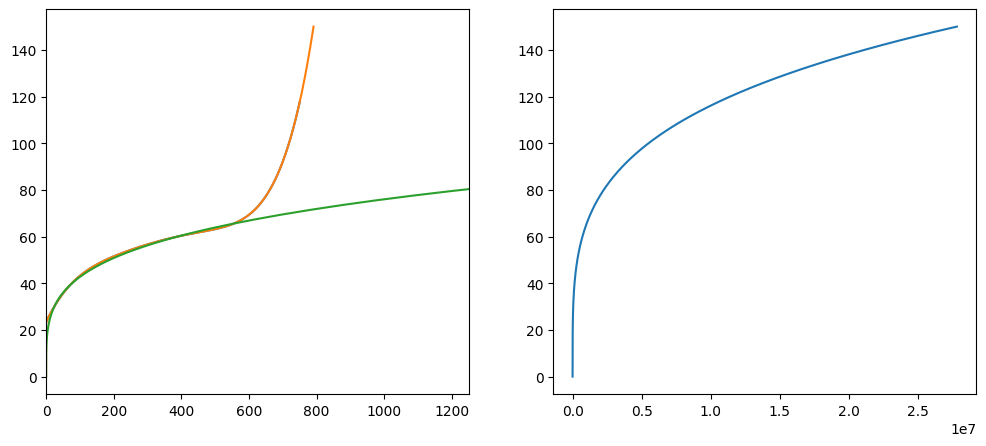

In [206]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def gaussian_2(v, A, vth, vd, o):
    p = 2
    vdf_unnormalized = np.exp(-np.abs((v - vd)  / (vth)) ** p)
    vdf =  vdf_unnormalized / np.trapz(vdf_unnormalized, v)
    return A*vdf+o

def gaussian_4(v, A, vth, vd, o):
    p = 4
    vdf_unnormalized = np.exp(-np.abs((v - vd)  / (vth)) ** p)
    vdf =  vdf_unnormalized / np.trapz(vdf_unnormalized, v)
    return A*vdf+o

def transformed_gaussian(v, A, vth, vd, o, D):
    vdf_unnormalized = np.exp(-((np.abs((v - vd)  / (vth)) ** 2) + D) ** 2)
    vdf =  vdf_unnormalized / np.trapz(vdf_unnormalized, v)
    return A*vdf+o

def lineout(array, w1, w2):
    width = np.shape(array)[0]
    length = np.shape(array)[1]
    line_data = array[w2,:]
    for i in range(length):
        line_data[i] = (1/(w2+1-w1))*np.sum(array[w1:w2+1,i])
    return line_data

def theoretical_dispersion(x,A,d):
    energy = A*(x**2+d**2)**2
    return energy

def theoretical_dispersion_relativistic_e(x,a,D):
    m = 9.1*10**-31
    c = 3*10**8
    E = m*c**2
    eV = 1.6*10**-19
    energy = (1/1000)*(1/eV)*0.5*(-E+np.sqrt(E**2+((eV*0.87*c)**2)*(1/D)*((((x-a)**2)+D)**2)))
    return energy

def theoretical_dispersion_relativistic_p(x,a,D):
    m = 1.67*10**-27
    c = 3*10**8
    E = m*c**2
    eV = 1.6*10**-19
    energy = (1/1000)*(1/eV)*0.5*(-E+np.sqrt(E**2+((eV*0.87*c)**2)*(1/D)*((((x-a)**2)+D)**2)))
    return energy

energy_data_protons = np.loadtxt('NEPPS_Dispersion_Protons_087T.txt', skiprows=1)
energy_data_electrons = np.loadtxt('NEPPS_Dispersion_Electrons_087T.txt', skiprows=1)

def linear_fit(x,m,c):
    y = m*x+c
    return y

def transform_electron_axis(x, R):
    energy = np.zeros(len(x))
    start = energy_data_electrons[-1,1]
    print(start)
    for i in range(len(x)):
        if np.abs((1/R)*x[i]-start) == np.min(np.abs((1/R)*x-start)):
            index = i
    print(index)
    energy[0:index] = np.interp((1/R)*x[0:index],np.array(energy_data_electrons[:,1]),np.array(energy_data_electrons[:,0]))

    deltax = energy_data_electrons[-1,1]-energy_data_electrons[-2,1]

    deltaE = energy_data_electrons[-1,0]-energy_data_electrons[-2,0]

    grad = deltaE/deltax

    intercept = energy_data_electrons[-1,0] - grad*energy_data_electrons[-1,1]

    energy[index:] = linear_fit((1/R)*x[index:], grad, intercept)

    return energy

def transform_proton_axis(x, R):
    energy = np.zeros(len(x))
    start = energy_data_protons[-1,1]
    print(start)
    for i in range(len(x)):
        if np.abs((1/R)*x[i]-start) == np.min(np.abs((1/R)*x-start)):
            index = i
    print(index)
    energy[0:index] = np.interp((1/R)*x[0:index],np.array(energy_data_protons[:,1]),np.array(energy_data_protons[:,0]))

    deltax = energy_data_protons[-1,1]-energy_data_protons[-2,1]

    deltaE = energy_data_protons[-1,0]-energy_data_protons[-2,0]

    grad = deltaE/deltax

    intercept = energy_data_protons[-1,0] - grad*energy_data_protons[-1,1]

    energy[index:] = linear_fit((1/R)*x[index:], grad, intercept)

    return energy

def proton_EtoX(E, R = 1):
    X = (1/R)*E
    position = 23.37 + 0.3098*X - 0.0014994*X**2 + 4.4981*(10**(-6))*X**3 - 6.984*(10**(-9))*X**4 + 4.288*(10**(-12))*X**5
    return position

def transform_proton(X, R):
    x = (1/R)*X
    Espace = np.linspace(0,2000,5*len(x))
    Xspace = proton_EtoX(Espace)
    energy = np.interp(x,Xspace,Espace)
    return energy

#Espace = np.linspace(0,2000,5*len(x_axis))
#plt.plot(Espace,proton_EtoX(Espace))

r = 10

x_axis = np.linspace(0,1500,150)

#print(transform_proton(x_axis,r)[:])
#print((1/r)*x_axis[:])

from scipy.optimize import curve_fit

Espace = np.linspace(0,500,1000)
Xspace = proton_EtoX(Espace)
ther, pcov = curve_fit(theoretical_dispersion, Xspace, Espace, p0=[0.000028,5])

def theoretical_transform(x, R):
    E_space = np.linspace(0,500,1000)
    X_space = proton_EtoX(E_space)
    ther_, pcov_ = curve_fit(theoretical_dispersion, X_space, E_space, p0=[0.000028,5])
    energy = theoretical_dispersion((1/R)*x, ther_[0], ther_[1])
    return energy

def electron_theoretical_transform(x, R):
    energy = theoretical_transform(x, R)
    return energy*1836

MS_signal_data = np.loadtxt('MS_signal.txt', skiprows=1) # Adjust delimiter if needed
MS_energy_axis = 1000*MS_signal_data[:,0]
MS_PSL_axis = MS_signal_data[:,1]

def MS_PSL_scale(Espace):
    PSL = np.interp(Espace,MS_energy_axis,MS_PSL_axis)
    return PSL

#plt.plot(theoretical_dispersion((1/r)*x_axis, 0.000028, 5),(1/r)*x_axis)

#fit = theoretical_dispersion((1/r)*x_axis, ther[0], ther[1])

#plt.plot(fit,(1/r)*x_axis)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(np.linspace(0,750,1000),proton_EtoX(np.linspace(0,750,1000)))

axs[0].plot(transform_proton(x_axis,r),(1/r)*x_axis)

axs[0].plot(theoretical_transform(x_axis,r),(1/r)*x_axis)

axs[0].set_xlim([0,1250])

axs[1].plot(electron_theoretical_transform(x_axis,r),(1/r)*x_axis)

103.4301408
103
96.96670344
96


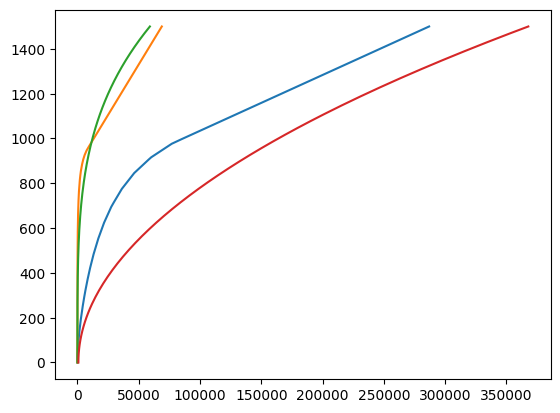

In [205]:
plt.plot(transform_electron_axis(x_axis,10),x_axis)
plt.plot(transform_proton_axis(x_axis,10),x_axis)


ther_, pcov_ = curve_fit(theoretical_dispersion, (1/10)*energy_data_electrons[:,1], energy_data_electrons[:,0], p0=[0.0028,5])

energy = theoretical_dispersion((1/10)*x_axis, ther_[0], ther_[1])

plt.plot(theoretical_dispersion_relativistic_p((1/10000)*x_axis,0.001,0.012**2),x_axis)
plt.plot(theoretical_dispersion_relativistic_e((1/10000)*x_axis,0.0,0.008**2),x_axis)
#plt.plot(energy,x_axis)

C:\Users\rayne\AppData\Local\Temp\ipykernel_22380\473844564.py:73: OptimizeWarning: Covariance of the parameters could not be estimated
  ther_, pcov_ = curve_fit(theoretical_dispersion, X_space, E_space, p0=[0.000028,5])


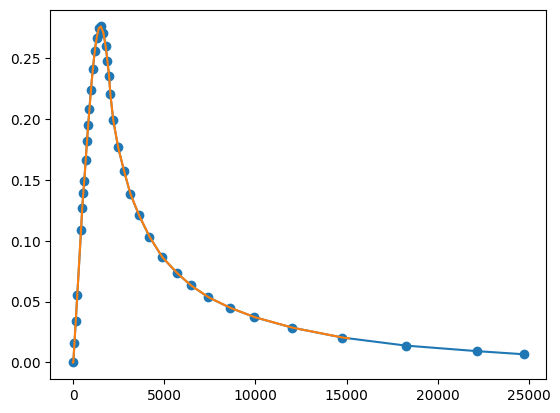

In [ ]:
Proton_PSL_data = np.loadtxt('Proton_PSL_linylinx.txt', delimiter=',', skiprows=1)
Proton_PSL_data_low = np.loadtxt('Proton_PSL_low.txt', delimiter=',', skiprows=1)

TR_proton_energy_axis = 1000*Proton_PSL_data[:,0]
TR_proton_PSL_axis = Proton_PSL_data[:,1]

plt.plot(TR_proton_energy_axis,TR_proton_PSL_axis)

plt.scatter(TR_proton_energy_axis,TR_proton_PSL_axis)

def TR_proton_PSL_scale(Espace):
    PSL = np.interp(Espace,TR_proton_energy_axis,TR_proton_PSL_axis)
    return PSL

plt.plot(theoretical_transform(x_1_29_axis,10),TR_proton_PSL_scale(theoretical_transform(x_1_29_axis,10)))

C:\Users\rayne\AppData\Local\Temp\ipykernel_22380\473844564.py:73: OptimizeWarning: Covariance of the parameters could not be estimated
  ther_, pcov_ = curve_fit(theoretical_dispersion, X_space, E_space, p0=[0.000028,5])


(100,)
(35,)


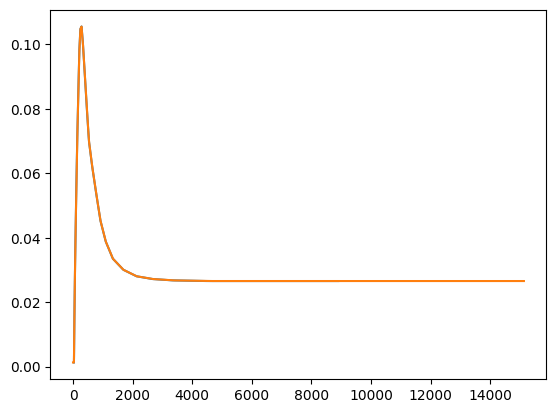

In [5]:
import numpy as np

# Assuming your text file is named 'data.txt' and contains a 2D array
energy_data = np.loadtxt('Electron_Dispersion_Z_vs_Ebeam_0028T.txt', skiprows=8) # Adjust delimiter if needed

MS_signal_data = np.loadtxt('MS_signal.txt', skiprows=1) # Adjust delimiter if needed
MS_energy_axis = 1000*MS_signal_data[:,0]
MS_PSL_axis = MS_signal_data[:,1]
#plt.loglog(MS_energy_axis,MS_PSL_axis)
plt.plot(MS_energy_axis,MS_PSL_axis)
plt.plot(theoretical_transform(x_1_29_axis,10),MS_PSL_scale(theoretical_transform(x_1_29_axis,10)))
print(np.shape(energy_data[:,0]))
print(np.shape(MS_energy_axis))
#plt.xlim([0,500])
#print(np.shape(data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


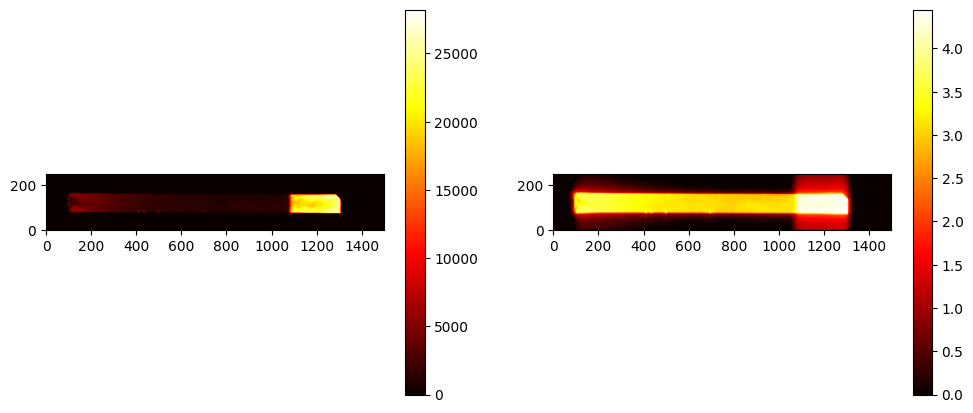

In [3]:
import h5py
import numpy as np
import cv2

with h5py.File('PLATE_1_SHOT_29.h5', "r") as f:

    base_items = list(f.items())
    #print('items in the base directory:', base_items)

    attributes = f.get('/ATTRIBUTES')
    attributes_list = list(attributes.items())
    #print('items in the ATTRIBUTES directory:', attributes_list)

    shot_image_folder = f.get('/ATTRIBUTES/PSL_IMAGE')
    shot_image_list = list(shot_image_folder.items())
    #print('items in the PLATE_IMG directory:', shot_image_list)

    shot_data_folder = f.get('/ATTRIBUTES/PSL_IMAGE/DATA')
    shot_data_list = list(shot_data_folder.items())
    #print('items in the PLATE_IMG directory:', shot_data_list)

    shot_data = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/DATA')
    shot_data = np.array(shot_data)
    #print(type(shot_data))

    x_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/X_AXIS')
    x_axis = np.array(x_axis)
    print(type(x_axis))

    y_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/Y_AXIS')
    y_axis = np.array(y_axis)
    print(type(y_axis))

    import matplotlib.pyplot as plt

    #plt.imshow(shot_data)
    extent = (np.min(x_axis),np.max(x_axis),np.min(y_axis),np.max(y_axis))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im1 = axs[0].imshow(shot_data, cmap='hot', origin='lower')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].set_title('')
    plt.colorbar(im1, ax=axs[0], label='')

    im2 = axs[1].imshow((1/np.log(10))*np.log(np.abs(shot_data+1)), cmap='hot', origin='lower')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title('')
    plt.colorbar(im2, ax=axs[1], label='')

NEPPS_1_29= shot_data
x_1_29_axis = x_axis

990.4487
356
632
420
426
489
503
[3.81450544e+05 2.73645757e-02 1.41249204e+03]
[6.76875811e+05 1.77449704e+00 1.87442669e+03]
[1.44123825e+05 1.48865216e-01 9.22015555e+04 4.20064456e-03
 6.74321780e-01]


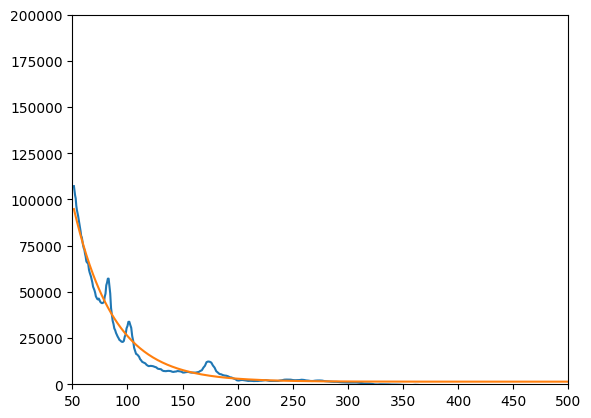

In [43]:
import numpy as np

line = lineout(NEPPS_1_29, 80, 150)
E_axis = transform_proton(x_1_29_axis,10)
proton_PSL_scale = TR_proton_PSL_scale(E_axis)

index = (np.append((np.append(np.linspace(391,420,29),np.linspace(426,449,23))),np.linspace(489,503,14))).astype(int)
E_axis_featureless = np.delete(E_axis,index, None)
line_featureless = np.delete(line,index, None)
proton = np.delete(proton_PSL_scale,index, None)

#plt.plot(E_axis,10000*proton_PSL_scale)
#plt.plot(E_axis[359:639],line[359:639])
plt.plot(E_axis[359:639],np.divide(line[359:639]-1402,proton_PSL_scale[359:639]))

#plt.plot(E_axis_featureless,np.divide(line_featureless-1402,proton))

plt.ylim([0,200000])
plt.xlim([50,500])
print(np.min(line[400:1000]))

def find_exp(E, A, a, shift):
    func = (A*np.exp(-a*E))+shift
    return func

def find_exp_proton(E, A, a, shift):
    func = (A*np.exp(-a*E))*TR_proton_PSL_scale(E)+shift
    return func

def find_2exp_proton(E, A, a, B, b, shift):
    func = ((A*np.exp(-a*E))+(B*np.exp(-b*E)))*TR_proton_PSL_scale(E)+shift
    return func

for i in range(len(E_axis)):
    start = 50
    if np.abs(E_axis[i]-start) == np.min(np.abs(E_axis-start)):
        start_i = i

for i in range(len(E_axis)):
    end = 500
    if np.abs(E_axis[i]-end) == np.min(np.abs(E_axis-end)):
        end_i = i

#############################################3

for j in range(len(E_axis)):
    start = 90
    if np.abs(E_axis[j]-start) == np.min(np.abs(E_axis-start)):
        start_j = j

for j in range(len(E_axis)):
    end =95
    if np.abs(E_axis[j]-end) == np.min(np.abs(E_axis-end)):
        end_j = j


for k in range(len(E_axis)):
    start = 160
    if np.abs(E_axis[k]-start) == np.min(np.abs(E_axis-start)):
        start_k = k

for k in range(len(E_axis)):
    end =180
    if np.abs(E_axis[k]-end) == np.min(np.abs(E_axis-end)):
        end_k = k

print(start_i)
print(end_i)

print(start_j)
print(end_j)


print(start_k)
print(end_k)

ther_1, pcov_1 = curve_fit(find_exp_proton, E_axis[start_i:end_i], line[start_i:end_i], p0=[6.76398671e+06, 4.68818512e-04, 4.24476726e+03], bounds=(0, np.inf))
fit1 = find_exp_proton(E_axis, ther_1[0], ther_1[1], ther_1[2])
fit1_exp = find_exp(E_axis, ther_1[0], ther_1[1], ther_1[2])
#plt.plot(E_axis,fit1)
plt.plot(E_axis[359:639],fit1_exp[359:639])


ther_1a, pcov_1a = curve_fit(find_exp_proton, E_axis_featureless[start_i:end_i-66], line_featureless[start_i:end_i-66], p0=[6.76398671e+06, 4.68818512e-04, 4.24476726e+03], bounds=(0, np.inf))
fit1a = find_exp_proton(E_axis_featureless, ther_1a[0], ther_1a[1], ther_1a[2])
fit1a_exp = find_exp(E_axis_featureless, ther_1a[0], ther_1a[1], ther_1a[2])

#plt.plot(E_axis_featureless[359:573],fit1a_exp[359:573])


ther_2, pcov_2 = curve_fit(find_exp_proton, E_axis[start_j:end_j], line[start_j:end_j], p0=[6.76398671e+05, 4.68818512e-05, 4.24476726e+03], bounds=(0, np.inf))
fit2 = find_exp_proton(E_axis, ther_2[0], ther_2[1], ther_2[2])
#plt.plot(E_axis,fit2)

ther_3, pcov_3 = curve_fit(find_2exp_proton, E_axis[start_k:end_k], line[start_k:end_k], p0=[2.76135864e+05, 2.12358458e-02, 1.99242499e+04, 5.90269774e-03, 1000], bounds=(0, np.inf))
fit3 = find_2exp_proton(E_axis, ther_3[0], ther_3[1], ther_3[2], ther_3[3], ther_3[4])
#plt.plot(E_axis,fit3)

#plt.plot(E_axis,fit1+fit2-ther_2[2])

print(ther_1)
print(ther_2)
print(ther_3)

In [ ]:
line = lineout(NEPPS_1_29, 80, 150)
E_axis = theoretical_transform(x_1_29_axis,10)
proton_PSL_scale = TR_proton_PSL_scale(E_axis)
#plt.plot(E_axis,10000*proton_PSL_scale)
#plt.plot(E_axis,line)
plt.plot(E_axis,np.divide(line-990,proton_PSL_scale))
plt.ylim([0,50000])
plt.xlim([50,3000])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


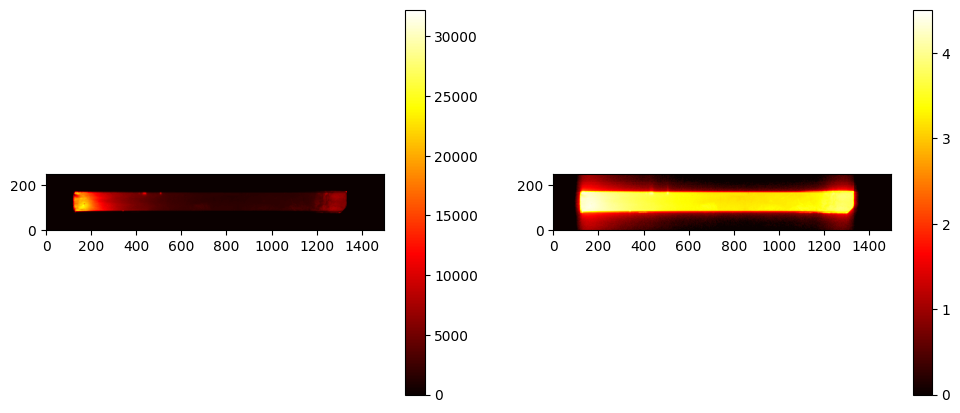

In [44]:
import h5py
import numpy as np
import cv2

with h5py.File('PLATE_2_SHOT_29.h5', "r") as f:

    base_items = list(f.items())
    #print('items in the base directory:', base_items)

    attributes = f.get('/ATTRIBUTES')
    attributes_list = list(attributes.items())
    #print('items in the ATTRIBUTES directory:', attributes_list)

    shot_image_folder = f.get('/ATTRIBUTES/PSL_IMAGE')
    shot_image_list = list(shot_image_folder.items())
    #print('items in the PLATE_IMG directory:', shot_image_list)

    shot_data_folder = f.get('/ATTRIBUTES/PSL_IMAGE/DATA')
    shot_data_list = list(shot_data_folder.items())
    #print('items in the PLATE_IMG directory:', shot_data_list)

    shot_data = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/DATA')
    shot_data = np.array(shot_data)
    #print(type(shot_data))

    x_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/X_AXIS')
    x_axis = np.array(x_axis)
    print(type(x_axis))

    y_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/Y_AXIS')
    y_axis = np.array(y_axis)
    print(type(y_axis))

    import matplotlib.pyplot as plt

    #plt.imshow(shot_data)
    extent = (np.min(x_axis),np.max(x_axis),np.min(y_axis),np.max(y_axis))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im1 = axs[0].imshow(shot_data, cmap='hot', origin='lower')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].set_title('')
    plt.colorbar(im1, ax=axs[0], label='')

    im2 = axs[1].imshow((1/np.log(10))*np.log(np.abs(shot_data+1)), cmap='hot', origin='lower')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title('')
    plt.colorbar(im2, ax=axs[1], label='')

NEPPS_2_29= shot_data
x_2_29_axis = x_axis

C:\Users\rayne\AppData\Local\Temp\ipykernel_22380\473844564.py:73: OptimizeWarning: Covariance of the parameters could not be estimated
  ther_, pcov_ = curve_fit(theoretical_dispersion, X_space, E_space, p0=[0.000028,5])


309
653
174
323
[2.43810069e+05 5.94748102e-06 2.03385849e+03]
[6.88310153e+05 7.78336305e-05 7.16248881e+03]


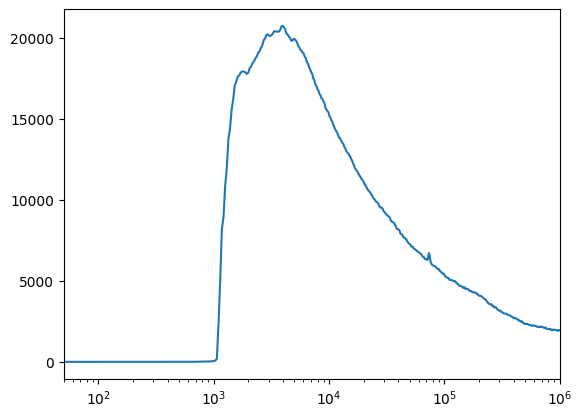

In [45]:
import numpy as np

line = lineout(NEPPS_2_29, 80, 150)
plt.semilogx(electron_theoretical_transform(x_2_29_axis,10),line)
E_axis = electron_theoretical_transform(x_2_29_axis,10)
#plt.ylim([0,50000])
#plt.xlim([0,15000000])
plt.xlim([50,1000000])
#plt.xlim([0,50000])

def find_exp_electron(E, A, a, shift):
    func = (A*np.exp(-a*E))*MS_PSL_scale(E)+shift
    return func

for i in range(len(E_axis)):
    start = 50000
    if np.abs(E_axis[i]-start) == np.min(np.abs(E_axis-start)):
        start_i = i

for i in range(len(E_axis)):
    end = 1000000
    if np.abs(E_axis[i]-end) == np.min(np.abs(E_axis-end)):
        end_i = i


for j in range(len(E_axis)):
    start = 5000
    if np.abs(E_axis[j]-start) == np.min(np.abs(E_axis-start)):
        start_j = j

for j in range(len(E_axis)):
    end =60000
    if np.abs(E_axis[j]-end) == np.min(np.abs(E_axis-end)):
        end_j = j

print(start_i)
print(end_i)

print(start_j)
print(end_j)

ther_1, pcov_1 = curve_fit(find_exp_electron, E_axis[start_i:end_i], line[start_i:end_i], p0=[6.76398671e+05, 4.68818512e-05, 4.24476726e+03])
fit1 = find_exp_electron(E_axis, ther_1[0], ther_1[1], ther_1[2])
#plt.plot(E_axis,fit1)

ther_2, pcov_2 = curve_fit(find_exp_electron, E_axis[start_j:end_j], line[start_j:end_j], p0=[6.76398671e+05, 4.68818512e-05, 4.24476726e+03])
fit2 = find_exp_electron(E_axis, ther_2[0], ther_2[1], ther_2[2])
#plt.plot(E_axis,fit2)

#plt.plot(E_axis,fit1+fit2-ther_2[2])

print(ther_1)
print(ther_2)

In [ ]:
electron_PSL_scale = MS_PSL_scale(E_axis)
#plt.plot(E_axis,PSL_scale)
#plt.plot(E_axis,line)
scaled_line_electron = np.divide(line-2030,electron_PSL_scale)
plt.plot(E_axis,scaled_line_electron)
plt.plot(E_axis,0*E_axis)
#plt.ylim([0,100000])
#plt.xlim([50,5000])
plt.xlim([0,500000])
plt.plot(E_axis, (2.4e+05)*np.exp(-(6e-06)*E_axis)+0e+03)
print(np.min(line[200:700]))
print(np.min(scaled_line_electron[400:900]))

In [ ]:
import numpy as np

print(np.shape(NEPPS_2_29))
line = lineout(NEPPS_2_29, 80, 150)
plt.plot(x_2_29_axis,line)
print(np.shape(line))
print(np.shape(x_2_29_axis))
np.min(line[400:1200])
#plt.plot(shot_data[:,1000])
#print(x_units)

from scipy.optimize import curve_fit

gauss_i, pcov_i = curve_fit(gaussian_2, x_2_29_axis[150:900], line[150:900], p0=[3000000,300,150,46000])

fitted_gauss_i = gaussian_2(x_2_29_axis[150:900], gauss_i[0], gauss_i[1], gauss_i[2], gauss_i[3])

#plt.plot(x_2_29_axis[150:900],fitted_gauss_i)

gauss_i4, pcov_i4 = curve_fit(transformed_gaussian, x_7_28_axis[250:900], line[250:900], p0=[3000000,300,150,46000,1])

fitted_gauss_i4 = transformed_gaussian(x_7_28_axis[250:900], gauss_i4[0], gauss_i4[1], gauss_i4[2], gauss_i4[3], gauss_i4[4])

#plt.plot(x_7_28_axis[250:900],fitted_gauss_i4)
print(gauss_i4[4])

In [ ]:
import h5py
import numpy as np
import cv2

with h5py.File('PLATE_6_SHOT_28.h5', "r") as f:

    base_items = list(f.items())
    #print('items in the base directory:', base_items)

    attributes = f.get('/ATTRIBUTES')
    attributes_list = list(attributes.items())
    #print('items in the ATTRIBUTES directory:', attributes_list)

    shot_image_folder = f.get('/ATTRIBUTES/PSL_IMAGE')
    shot_image_list = list(shot_image_folder.items())
    #print('items in the PLATE_IMG directory:', shot_image_list)

    shot_data_folder = f.get('/ATTRIBUTES/PSL_IMAGE/DATA')
    shot_data_list = list(shot_data_folder.items())
    #print('items in the PLATE_IMG directory:', shot_data_list)

    shot_data = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/DATA')
    shot_data = np.array(shot_data)
    #print(type(shot_data))

    x_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/X_AXIS')
    x_axis = np.array(x_axis)
    print(type(x_axis))

    y_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/Y_AXIS')
    y_axis = np.array(y_axis)
    print(type(y_axis))

    import matplotlib.pyplot as plt

    #plt.imshow(shot_data)
    extent = (np.min(x_axis),np.max(x_axis),np.min(y_axis),np.max(y_axis))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im1 = axs[0].imshow(shot_data, cmap='hot', origin='lower')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].set_title('')
    plt.colorbar(im1, ax=axs[0], label='')

    im2 = axs[1].imshow((1/np.log(10))*np.log(np.abs(shot_data+1)), cmap='hot', origin='lower')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title('')
    plt.colorbar(im2, ax=axs[1], label='')

NEPPS_6_28= shot_data
x_6_28_axis = x_axis

In [ ]:
import numpy as np

line = lineout(NEPPS_6_28, 80, 150)
plt.plot(electron_theoretical_transform(x_2_29_axis,10),line)
#plt.ylim([0,200])
plt.xlim([0,100000])
plt.xlim([0,1000000])
#plt.xlim([0,10000000])

def find_exp_electron(E, A, a, shift):
    func = (A*np.exp(-a*E))*MS_PSL_scale(E)+shift
    return func

for i in range(len(E_axis)):
    start = 10000
    if np.abs(E_axis[i]-start) == np.min(np.abs(E_axis-start)):
        start_i = i

for i in range(len(E_axis)):
    end = 150000
    if np.abs(E_axis[i]-end) == np.min(np.abs(E_axis-end)):
        end_i = i


for j in range(len(E_axis)):
    start = 100000
    if np.abs(E_axis[j]-start) == np.min(np.abs(E_axis-start)):
        start_j = j

for j in range(len(E_axis)):
    end =800000
    if np.abs(E_axis[j]-end) == np.min(np.abs(E_axis-end)):
        end_j = j

print(start_i)
print(end_i)

print(start_j)
print(end_j)

fit = find_exp_electron(E_axis, 5000, 0.00002, 15)
#plt.plot(E_axis,fit)

ther_1, pcov_1 = curve_fit(find_exp_electron, E_axis[start_i:end_i], line[start_i:end_i], p0=[5000, 0.00002, 15], bounds=(0, np.inf))
fit1 = find_exp_electron(E_axis, ther_1[0], ther_1[1], ther_1[2])
plt.plot(E_axis,fit1)

ther_2, pcov_2 = curve_fit(find_exp_electron, E_axis[start_j:end_j], line[start_j:end_j], p0=[5000, 0.00001, 0], bounds=(0, np.inf))
fit2 = find_exp_electron(E_axis, ther_2[0], ther_2[1], ther_2[2])
plt.plot(E_axis,fit2)

plt.plot(E_axis,fit1+fit2-ther_1[2])

print(ther_1)
print(ther_2)

In [ ]:
import numpy as np

print(np.shape(NEPPS_6_28))
line = lineout(NEPPS_6_28, 80, 150)
plt.plot(x_6_28_axis,line)
print(np.shape(line))
print(np.shape(x_6_28_axis))
np.min(line[400:1200])
#plt.plot(shot_data[:,1000])
#print(x_units)

from scipy.optimize import curve_fit

gauss_i, pcov_i = curve_fit(gaussian_2, x_6_28_axis[150:900], line[150:900], p0=[3000000,300,150,46000])

fitted_gauss_i = gaussian_2(x_6_28_axis[150:900], gauss_i[0], gauss_i[1], gauss_i[2], gauss_i[3])

#plt.plot(x_6_28_axis[150:900],fitted_gauss_i)

gauss_i4, pcov_i4 = curve_fit(transformed_gaussian, x_7_28_axis[250:900], line[250:900], p0=[3000000,300,150,46000,1])

fitted_gauss_i4 = transformed_gaussian(x_7_28_axis[250:900], gauss_i4[0], gauss_i4[1], gauss_i4[2], gauss_i4[3], gauss_i4[4])

#plt.plot(x_7_28_axis[250:900],fitted_gauss_i4)
print(gauss_i4[4])

In [ ]:
import h5py
import numpy as np
import cv2

with h5py.File('PLATE_7_SHOT_28.h5', "r") as f:

    base_items = list(f.items())
    #print('items in the base directory:', base_items)

    attributes = f.get('/ATTRIBUTES')
    attributes_list = list(attributes.items())
    #print('items in the ATTRIBUTES directory:', attributes_list)

    shot_image_folder = f.get('/ATTRIBUTES/PSL_IMAGE')
    shot_image_list = list(shot_image_folder.items())
    #print('items in the PLATE_IMG directory:', shot_image_list)

    shot_data_folder = f.get('/ATTRIBUTES/PSL_IMAGE/DATA')
    shot_data_list = list(shot_data_folder.items())
    #print('items in the PLATE_IMG directory:', shot_data_list)

    shot_data = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/DATA')
    shot_data = np.array(shot_data)
    #print(type(shot_data))

    x_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/X_AXIS')
    x_axis = np.array(x_axis)
    print(type(x_axis))

    y_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/Y_AXIS')
    y_axis = np.array(y_axis)
    print(type(y_axis))

    import matplotlib.pyplot as plt

    #plt.imshow(shot_data)
    extent = (np.min(x_axis),np.max(x_axis),np.min(y_axis),np.max(y_axis))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im1 = axs[0].imshow(shot_data, cmap='hot', origin='lower')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].set_title('')
    plt.colorbar(im1, ax=axs[0], label='')

    im2 = axs[1].imshow((1/np.log(10))*np.log(np.abs(shot_data+1)), cmap='hot', origin='lower')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title('')
    plt.colorbar(im2, ax=axs[1], label='')

NEPPS_7_28= shot_data
x_7_28_axis = x_axis

In [ ]:
import numpy as np

line = lineout(NEPPS_7_28, 80, 150)
plt.plot(theoretical_transform(x_1_29_axis,20),line)
plt.ylim([0,500])
plt.xlim([0,1000])

In [ ]:
import numpy as np

print(np.shape(NEPPS_7_28))
line = lineout(NEPPS_7_28, 80, 150)
plt.plot(x_7_28_axis,line)
print(np.shape(line))
print(np.shape(x_7_28_axis))
np.min(line[400:1200])
#plt.plot(shot_data[:,1000])
#print(x_units)

from scipy.optimize import curve_fit

#plt.plot(x0_axis,gaussian_H(x0_axis,3000000,300,150,46000))

gauss_i, pcov_i = curve_fit(gaussian_2, x_7_28_axis[150:900], line[150:900], p0=[3000000,300,150,46000])

fitted_gauss_i = gaussian_2(x_7_28_axis[150:900], gauss_i[0], gauss_i[1], gauss_i[2], gauss_i[3])

#plt.plot(x_7_28_axis[150:900],fitted_gauss_i)

gauss_i4, pcov_i4 = curve_fit(transformed_gaussian, x_7_28_axis[250:900], line[250:900], p0=[3000000,300,150,46000,1])

fitted_gauss_i4 = transformed_gaussian(x_7_28_axis[250:900], gauss_i4[0], gauss_i4[1], gauss_i4[2], gauss_i4[3], gauss_i4[4])

#plt.plot(x_7_28_axis[250:900],fitted_gauss_i4)
print(gauss_i4[4])

In [ ]:
import h5py
import numpy as np
import cv2


### KEEP ALL THIS

with h5py.File('PLATE_1_SHOT_29.h5', "r") as f:

    base_items = list(f.items())
    print('items in the base directory:', base_items)

    attributes = f.get('/ATTRIBUTES')
    attributes_list = list(attributes.items())
    print('items in the ATTRIBUTES directory:', attributes_list)

    shot_image_folder = f.get('/ATTRIBUTES/PSL_IMAGE')
    shot_image_list = list(shot_image_folder.items())
    print('items in the PLATE_IMG directory:', shot_image_list)

    shot_data_folder = f.get('/ATTRIBUTES/PSL_IMAGE/DATA')
    shot_data_list = list(shot_data_folder.items())
    print('items in the PLATE_IMG directory:', shot_data_list)

    shot_data = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/DATA')
    shot_data = np.array(shot_data)
    print(type(shot_data))

    data_label = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/DATA_LABEL')
    data_label = np.array(data_label)
    print(type(data_label))

    x_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/X_AXIS')
    x_axis = np.array(x_axis)
    print(type(x_axis))

    y_axis = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/Y_AXIS')
    y_axis = np.array(y_axis)
    print(type(y_axis))

    x_label = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/X_LABEL')
    x_label = np.array(x_label)
    print(type(x_label))

    data_units = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/DATA_UNITS')
    data_units = np.array(data_units)
    print(type(data_units))
    print(data_units)

    title = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/TITLE')
    title = np.array(title)
    print(type(title))

    x_units = f.get('/ATTRIBUTES/PSL_IMAGE/DATA/X_UNITS')
    x_units = np.array(x_units)
    print(type(x_units))
    print(x_units)
    #print(x_axis)
    #print(y_axis)

    metadata_folder = f.get('/METADATA_CATEGORIES')
    metadata_list = list(metadata_folder.items())
    print('items in the METADATA_CATEGORIES directory:', metadata_list)

    natural_key_folder = f.get('/METADATA_CATEGORIES/NATURAL_KEY')
    natural_key_list = list(natural_key_folder.items())
    print('items in the NATURAL_KEY directory:', natural_key_list)

    pedigree_folder = f.get('/PEDIGREE')
    pedigree_list = list(pedigree_folder.items())
    print('items in the PEDIGREE directory:', pedigree_list)

    pedigree_calibration_folder = f.get('/PEDIGREE/PEDIGREE_CALIBRATION')
    pedigree_calibration_list = list(pedigree_calibration_folder.items())
    print('items in the PEDIGREE_CALIBRATION directory:', pedigree_calibration_list)
    
    pedigree_calibration_folder_0 = f.get('/PEDIGREE/PEDIGREE_CALIBRATION/0')
    pedigree_calibration_list_0 = list(pedigree_calibration_folder_0.items())
    print('items in the PEDIGREE_CALIBRATION_0 directory:', pedigree_calibration_list_0)

    pedigree_calibration_folder_0_component_desc = f.get('/PEDIGREE/PEDIGREE_CALIBRATION/0/COMPONENT_DESC')
    print(pedigree_calibration_folder_0_component_desc[0])


    import matplotlib.pyplot as plt

    #print(shot_data)

    #plt.imshow(shot_data)
    extent = (np.min(x_axis),np.max(x_axis),np.min(y_axis),np.max(y_axis))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im1 = axs[0].imshow(shot_data, cmap='hot', origin='lower')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].set_title('')
    plt.colorbar(im1, ax=axs[0], label='')

    im2 = axs[1].imshow((1/np.log(10))*np.log(np.abs(shot_data+1)), cmap='hot', origin='lower')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_title('')
    plt.colorbar(im2, ax=axs[1], label='')

